## Preface



First, load relevant dataset:



In [ ]:
import cfe

## Choose dataset ##
USE = "ICRISAT"
#USE = "Tanzania"

# Results can be made persistent by saving them, and then re-loading...
if USE=="ICRISAT":
    r = cfe.from_dataset('./IndianICRISAT/indian_icrisat.ds')
    DIR = "./IndianICRISAT/"
elif USE=="Tanzania":
    r = cfe.from_dataset('./TanzanianNPS/tanzanian_nps.ds')
    DIR = "./TanzanianNPS/"
else:
    raise ValueError("No such value of USE")


Also, choose reference prices. Here we choose first market in first
period, but this is a matter of choice.



In [1]:
t = r.firstround  # First round
m = r.coords['m'][0] # First market

x = r.y.sum('i')
x = x.where(x>0).sel(t=t,m=m).median('j') # Budget (median household)

# Note selection of prices for first market in first period
p = r.prices.sel(t=t,m=m).fillna(1).copy()

p.to_dataframe().fillna(1).squeeze()

And with $(x,p)$ defined we can calculate example demands:



In [1]:
c=r.demands(x,p)
c

# Out[9]:
# text/plain
i
Beef Including Minced Sausage                                   0.241992
Bottled/Canned Soft Drinks (Soda, Juice, Water)              1768.747224
Bread                                                         200.305064
Buns, Cakes And Biscuits                                      400.902551
Cassava Fresh                                                  13.468608
Chicken And Other Poultry                                     167.299425
Citrus Fruits (Oranges, Lemon, Tangerines, Etc.)             9340.793779
Coconuts (Mature/Immature)                                    237.404094
Cooking Bananas, Plantains                                    652.945691
Cooking Oil                                                   339.852002
Dried/Salted/Canned Fish And Seafood (Incl. Dagaa)            203.900051
Eggs                                                            1.489923
Fresh Fish And Seafood (Including Dagaa)                     2185.258613
Fresh Milk                

Finally, define a function to change a single price in the vector $p$:



In [1]:
def my_prices(p0,p=p,i='Coconut'):
    p = p.copy()
    p.loc[i] = p0
    return p

## Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
quantities using `cfe.Result.demands`.  Next we want to think about
how to map these into bundles of *nutrients*.  The information needed
for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
such as the [USDA Nutrition DataBase](https://ndb.nal.usda.gov/ndb/doc/apilist/API-FOOD-REPORTV2.md)).   Here we&rsquo;ve adapted (with
thanks to Alessandro Tarozzi of the Universitat Pompeu Fabra) a food
conversion table developed by Gopalan et al (1980) to the foods
reported in the Indian ICRISAT data:



In [1]:
import pandas as pd

if USE=="ICRISAT":
    fct = pd.read_pickle('./IndianICRISAT/fct.df')
elif USE=="Tanzania":
    fct = pd.read_pickle('./TanzanianNPS/fct.df')

# Change some labels
d={'protein':'Protein',
   'protein g':'Protein',
   'fat':'Fat',
   'energy_kcal':'Calories',
   'energy kcal':'Calories',
   'calcium':'Calcium',
   'ca mg':'Calcium',
   'betacarotene':'Betacarotene',
   'thiamine':'Thiamine',
   'riboflavin':'Riboflavin',
   'niacin':'Niacin',
   'iron':'Iron',
   'fe mg':'Iron',
   'ascorbic_total':'Ascorbic Acid',
   'vit a ug':'Vitamin A',
   'vit b6 mg':'Vitamin B6',
   'vit b12 ug':'Vitamin B12',
   'vit d ug':'Vitamin D',
   'vit e ug':'Vitamin E',
   'vit c mg':'Vitamin C',
   'mg mg':'Magnesium',
   'zn mg':'Zinc'}

fct = fct.rename(columns=d) #[list(d.values())]

# Fix capitalization (to match food labels)
fct.index = fct.reset_index()['Item name'].str.title()

# Replace missing with zeros
fct = fct.fillna(0)

try:
    fct.index = fct.index.droplevel('unit')
except AttributeError: pass # No units?

fct.columns

# Out[28]:
# text/plain
Index(['Calories', 'Protein', 'Vitamin A', 'Vitamin D', 'Vitamin E',
       'Vitamin C', 'Vitamin B6', 'Vitamin B12', 'Calcium', 'Magnesium',
       'Iron', 'Zinc'],
      dtype='object')

We need the index of the Food Conversion Table (FCT) to match up with
the index of the vector of quantities demanded.   To manage this we
make use of the `align` method for `pd.DataFrames`:



In [1]:
# Index of fct includes names of goods and also units.  Drop the latter:
try:
    fct.index = fct.index.droplevel('unit')
except AttributeError: pass # not a multiindex?

# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(c,axis=0,join='inner')
print(fct0.index)

Now, since rows of `fct0` and `c0` match, we can obtain nutritional
outcomes from the inner (or dot, or matrix) product of the transposed
`fct0` and `c0`:



In [1]:
# The @ operator means matrix multiply
N = fct0.T@c0
N

Of course, since we can compute the nutritional content of a vector of
consumption goods `c0`, we can also use our demand functions to
compute nutrition as a *function* of prices and budget.



In [1]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

With this `nutrient_demand` function in hand, we can see how nutrient
outcomes vary with budget, given prices:



In [1]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(x/5,x*5,50)

UseNutrients = ['Protein','Calories','Iron','Calcium']

plt.plot(X,pd.concat({myx:np.log(nutrient_demand(x,p))[UseNutrients] for myx in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient')

Now how does nutrition vary with prices?



In [1]:
if USE=="ICRISAT":
    USE_GOOD = 'Bengalgram dhal'
elif USE=="Tanzania":
    USE_GOOD = 'Ripe Bananas'
else:
    raise ValueError("No such value of USE")

ref_price = r.prices.sel(i=USE_GOOD,t=t,m=m)

P = np.linspace(ref_price/10,ref_price*10,50)

plt.plot(P,pd.concat({p0:np.log(nutrient_demand(x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log price')
plt.ylabel('log nutrient')

## Nutritional requirements



Individuals have nutritional requirements established by nutrition
scientists.  Here are some standards established by the Indian
National Institute of Nutrition:



### Nutritional needs of individuals



#### Recommended Daily Allowances: India



| Sex-Age|Calories|Protein|Fat|Calcium|Iron|Betacarotene|Thiamine|Riboflavin|Niacin|Ascorbic Acid|
|---|---|---|---|---|---|---|---|---|---|---|
| C 0-0.5||||500|||.2|.3||25|
| C 0.5-1|||19|500|5|2800|.3|.4||25|
| C 1-3|1060|16.7|27|600|9|3200|.5|.6|8|40|
| C 4-6|1350|20.1|25|600|13|3200|.7|.8|11|40|
| C 7-9|1690|29.5|30|600|16|4800|.8|1.|13|40|
| B 10-12|2190|39.9|35|800|21|4800|1.1|1.3|15|40|
| G 10-12|2010|40.4|35|800|27|4800|1.|1.2|13|40|
| B 13-15|2750|54.3|45|800|32|4800|1.4|1.6|16|40|
| G 13-15|2330|51.9|40|800|27|4800|1.2|1.4|14|40|
| B 16-17|3020|61.5|50|800|28|4800|1.5|1.8|17|40|
| G 16-17|2440|55.5|35|800|26|4800|1.|1.2|14|40|
| M|2730|60|30|600|17|4800|1.4|1.4|18|40|
| W|2230|55|25|1200|21|4800|1.1|1.3|14|40|



#### Recommended Daily Allowances: Tanzania



| Sex-Age|Calories|Protein|Vitamin A|Vitamin B6|Vitamin B12|Vitamin C|Vitamin D|Vitamin E|Calcium|Iron|Magnesium|Zinc|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
| C 0-2|680|13.05|395833|0.35|0.725|28.75|5|3850|437.5|4.325|51.25|3.775|
| C 2-5|900|13.8|400000|0.55|1.05|30|5|5000|550|5.05|68|4.45|
| C 6-9|1260|19.581875|400000|0.9|1.65|33.75|5|6500|675|6.875|94|5.4|
| C 10-14|1650|31.4712|400000|1.35|2.43|38.5|5|8400|840|9.22|128|6.65|
| C 15-17|2020|42.126|400000|1.67|3|41.67|5|9670|966.67|10.867|153.33|7.6|
| Men|2800|45.8344|600000|1.5|2.4|45|5|10000|1150|9|260|7|
| Women|2290|45.8344|500000|1.4|2.4|45|5|5000|1150|20|220|4.9|



### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in the ICRISAT villages, the number of
different kinds of people can be computed by averaging over households:



In [1]:
# In first round, averaged over households and villages
zbar = r.z.sel(t=r.firstround).mean(['j','m'])[:-1] # Leave out log HSize

Now, the inner/dot/matrix product between `zbar` and the `rda`
DataFrame of requirements will give us minimum requirements for the
average household:



In [1]:
rda = pd.read_pickle(DIR+'rda.df')

# This matrix product gives minimum nutrient requirements for average
# household in 1975
hh_rda = rda.replace('',0).T@zbar
hh_rda

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet.



In [1]:
def nutrient_adequacy_ratio(x,p):
    return nutrient_demand(x,p)/hh_rda

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



# Out[36]:


# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

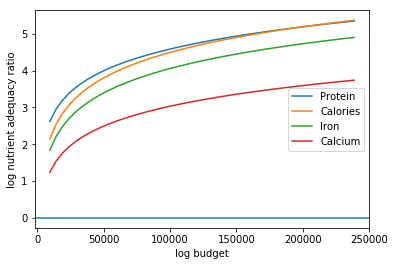

In [1]:
plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



# Out[38]:


# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

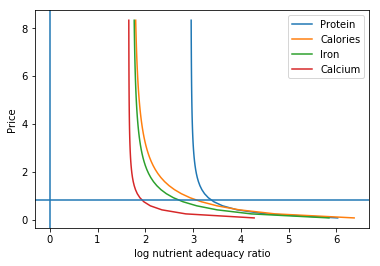

In [1]:
poorer_x = x/2

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(poorer_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.axhline(p.sel(i=USE_GOOD).values)